# Проект для «Викишоп» с BERT

<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Александр! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

**Описание данных**

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела. 
     
    
 

<div class="alert alert-warning">


Совет: 
   
Вопросик, при желании можешь ответить )
    
    
- а почему по твоему была выбрана метрика f1? 
    
    
- а что если бы нам было нужно найти как можно больше токсичных комментариев, в этом случаи на какую метрику мы бы ориентировались?
    
    
- каким образом мы можем изменить функцию ошибки в модели, чтобы она максимизировала интересующую нас метрику (accuracy, f1, precision, roc-auc итп)?    



</div>

## Подготовка

### Импорты

In [51]:
from json import loads
import re
import warnings

import nltk
import numpy as np
import pandas as pd
import spacy
import torch

from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import PunktTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from wordcloud import WordCloud

tqdm.pandas()

### Константы и используемые функции

In [2]:
nltk.download(['punkt', 'stopwords'])
RANDOM_STATE = 42
GSCV_LOG_REGRESSION_CONFIG = {
    'C': [.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', 'elasticnet'],
}
GSCV_RAND_FOREST_CONFIG = {
    'max_depth': range(1, 6),
    'n_estimators': range(1, 202, 10),
}
GSCV_CAT_BOOSRT_CONFIG = {
    'learning_rate':[.1, .5, .8],
    'max_depth': range(1, 6),
    'n_estimators': range(50, 301, 50),
}
IS_BERT_TRAIN = True # Проводить ли обучение BERT
IS_SELECTION_PARAMETERS = False # Проводить ли заново подбор лучших параметров моделей
IS_LOCAL = False # Проект выполняется локально
STOPWORDS = set(stopwords.words('english'))
SPACY_NLP = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alexander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
def get_hist(data, bins=10, title=None, x_label=None, y_label='Количество случаев'):
    _, ax = plt.subplots(figsize=(8, 6))

    ax.hist(data, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    plt.show()

In [72]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[']", "", text)
    text = re.sub(r"[^\w]", " ", text)
    text = ' '.join(text.split())
    return text

In [73]:
def lemmatize(text, nlp):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc]).lower()

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>  

Добавил в конце приведение к нижнему регистру, так как почему-то spacy некоторые слова переводит из нижнего регистра в верхний. Например, i превращается в I. Не нашел, можно ли указанием параметров это изменить
</div>

Добавил в конце приведение к нижнему регистру, так как почему-то spacy некоторые слова переводит из нижнего регистра в верхний. Например, i превращается в I. Не нашел, можно ли указанием параметров это изменить

In [74]:
def clean_and_lemmatize(text, nlp):
    text = clean_text(text)
    return lemmatize(text, nlp)

In [75]:
def clean_stopwords(text, stopwords):
    return ' '.join([word for word in text.split() if word not in stopwords])

In [76]:
def get_popular_words(texts, top_n=10, title=None):
    fdist = FreqDist()
    tokens = (
        texts
        .progress_apply(lambda x: x.split())
        .values
    )
    for row in tokens:
        fdist.update(row)
    plt.figure(figsize=(12,6))
    fdist.plot(top_n, title=title, marker='|',)
    plt.show()
    return fdist

In [77]:
def get_wordcloud(text_tokens, title):
    text = ' '.join(text_tokens.values)
    plt.figure(figsize=(12, 6))
    plt.imshow(
        WordCloud().generate(text)
    )
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [79]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_one = features[target == 1]
    target_zeros = target[target == 0]
    target_one = target[target == 1]
    
    features_upsample = pd.concat([features_zeros] + [features_one] * repeat)
    target_upsample = pd.concat([target_zeros] + [target_one] * repeat)
    features_upsample, target_upsample = shuffle(
        features_upsample, target_upsample, random_state=RANDOM_STATE)
    
    return features_upsample, target_upsample

In [80]:
def selection_model_params(model, params, features, target, metric, cv=5, n_jobs=-1):
    gscv = GridSearchCV(
        model, params, cv=cv,
        scoring=metric,
        refit=False,
        return_train_score=True,
        verbose=2,
        n_jobs=n_jobs
    )
    gscv.fit(features, target)
    return pd.DataFrame(gscv.cv_results_).sort_values(
        by='mean_test_score', ascending=False
    )

In [81]:
def create_threshold_f1_plot(f1, thresholds):
    _, ax = plt.subplots(figsize=(5, 5))

    ax.step(f1, thresholds)
    ax.ylim([0.0, 1.05])
    ax.xlim([0.0, 1.0])
    ax.title("Кривая Thresholds-F1")
    ax.xlabel("F1")
    ax.ylabel("Thresholds")
    ax.grid(True)
    ax.gca().xaxis.set(ticks=np.arange(0, 1.1, .1))
    ax.gca().yaxis.set(ticks=np.arange(0, 1.1, .1))
    ax.show()

## EDA

In [11]:
data = pd.read_csv('data/toxic_comments.csv', index_col=0)

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    


Unnamed: 0 это "след" старых индексов. Если ты уберёшь первые 10 примеров и своего датасета, сохранишь его, а потом откроешь,  то появится столбец Unnamed: 0 начиная с цифры 9, и появится новый индексы начиная с нуля 


Но это мелочь,  даже не нужно ничего исправлять. Просто знай, чтобы увидев такое в чужом коде не удивляться что бы это могло означать

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [13]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Наличие дубликтов

In [14]:
data['text'].duplicated().sum()

0

В датасете нет дублирующихся текстов

### Дисбаланс классов

In [15]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

В датасете наблюдается сильный дисбаланс классов. Токсичные комментарии составляют лишь `10%` от всего датасета. Попробуем решить данную проблему 2 методами:  
1. Установкой весов классов
2. Увеличением выборки путем дублирования экземпляров меньшего класса

### Длина токсичных и нетоксичных комментариев

In [ ]:
data['len_text'] = data['text'].progress_apply(lambda x: len(x))

100%|██████████| 159292/159292 [00:00<00:00, 383499.97it/s]


In [58]:
data.query('toxic == 0')['len_text'].describe()

count    143106.000000
mean        403.956585
std         585.914845
min           6.000000
25%         102.000000
50%         216.000000
75%         452.000000
max        5000.000000
Name: len_text, dtype: float64

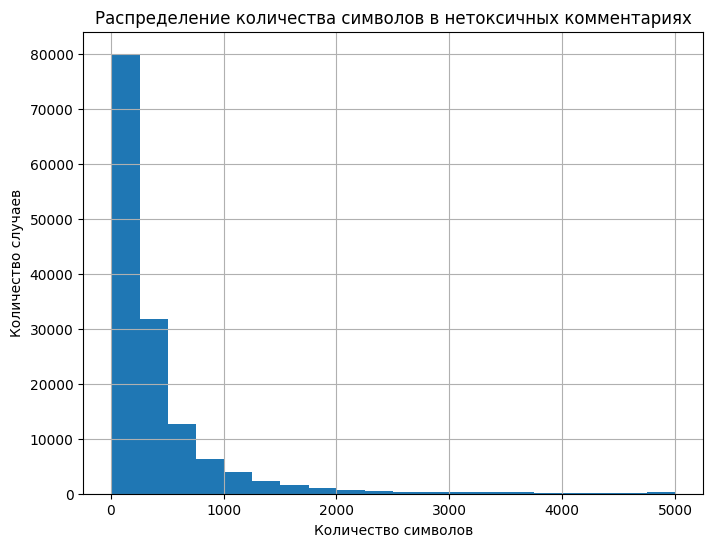

In [82]:
get_hist(
    data.query('toxic == 0')['len_text'],
    bins=20,
    title='Распределение количества символов в нетоксичных комментариях',
    x_label='Количество символов'
)

In [ ]:
data.query('toxic == 1')['len_text'].describe()

count    16186.000000
mean       302.932411
std        618.647890
min          5.000000
25%         61.000000
50%        128.000000
75%        282.750000
max       5000.000000
Name: len_text, dtype: float64

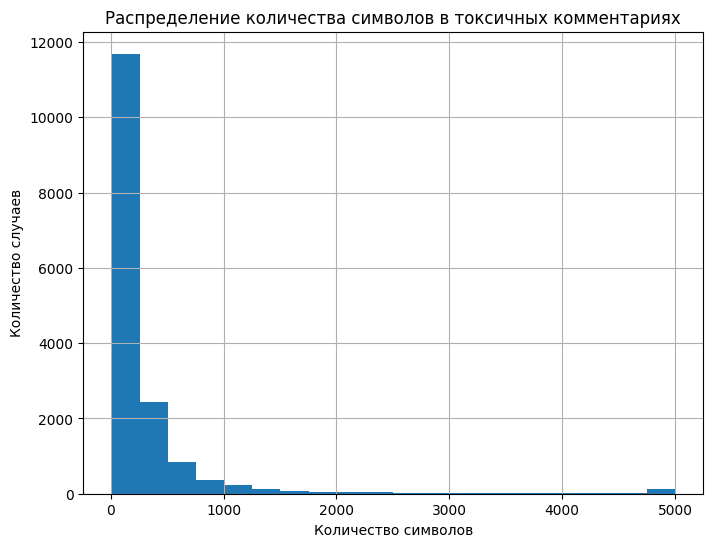

In [83]:
get_hist(
    data.query('toxic == 1')['len_text'],
    bins=20,
    title='Распределение количества символов в токсичных комментариях',
    x_label='Количество символов'
)

ВЫВОД

### Количество предложений в токсичных и нетоксичных комментариях

In [54]:
sent_detector = PunktTokenizer()
data['count_sentence'] = data['text'].progress_apply(
    lambda x, detector: len(detector.tokenize(x.strip())),
    detector=sent_detector
)
data.head()

100%|██████████| 159292/159292 [00:20<00:00, 7732.63it/s]


,text,toxic,count_sentence,len_text
0,Explanation\nWhy the edits made under my usern...,0,3,264
1,D'aww! He matches this background colour I'm s...,0,4,112
2,"Hey man, I'm really not trying to edit war. It...",0,3,233
3,"""\nMore\nI can't make any real suggestions on ...",0,4,622
4,"You, sir, are my hero. Any chance you remember...",0,2,67


In [18]:
data.query('toxic == 0')['count_sentence'].describe()

count    143106.000000
mean          4.400668
std           5.478545
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         358.000000
Name: count_sentence, dtype: float64

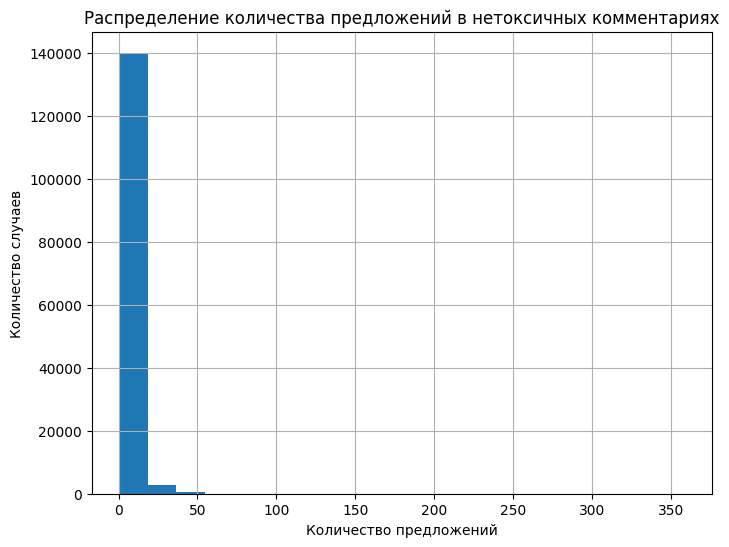

In [85]:
get_hist(
    data.query('toxic == 0')['count_sentence'],
    bins=20,
    title='Распределение количества предложений в нетоксичных комментариях',
    x_label='Количество предложений'
)

In [86]:
data.query('toxic == 1')['count_sentence'].describe()

count    16186.000000
mean         4.347399
std         13.924106
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        683.000000
Name: count_sentence, dtype: float64

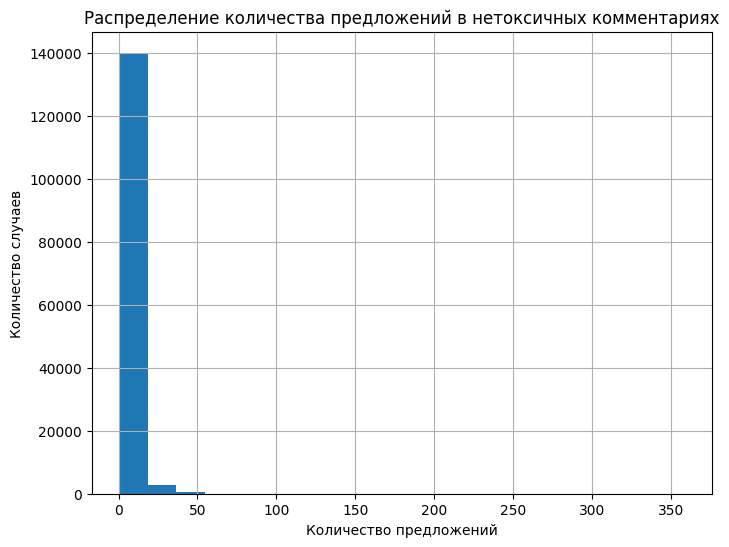

In [87]:
get_hist(
    data.query('toxic == 0')['count_sentence'],
    bins=20,
    title='Распределение количества предложений в нетоксичных комментариях',
    x_label='Количество предложений'
)

Среднее количество предложений в нетоксичных комментариях - `4.4`. Среднее количество предложений в токсичных комментариях - `4.3`. Данный признак поможет разделить тексты на необходимые классы

### Очистка текстов и лемматризация

In [24]:
data_100 = data[:100].copy()
data_100['text_clean_lemma'] = data_100['text'].progress_apply(clean_and_lemmatize, nlp=SPACY_NLP)
data_100.head()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 48.73it/s]


,text,toxic,count_sentence,len_text,text_clean_lemma
0,Explanation\nWhy the edits made under my usern...,0,3,264,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,4,112,daww he match this background colour i m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,3,233,hey man i m really not try to edit war its jus...
3,"""\nMore\nI can't make any real suggestions on ...",0,4,622,more i can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,2,67,you sir be my hero any chance you remember wha...


In [26]:
data_100['text_clean_lemma_without_stopwords'] = data_100['text_clean_lemma'].progress_apply(
    clean_stopwords, stopwords=STOPWORDS
)

100%|██████████| 100/100 [00:00<00:00, 22214.42it/s]


### Подсчет количество слов в комментариях

In [27]:
data_100['count_words'] = data_100['text_clean_lemma_without_stopwords'].progress_apply(lambda x: len(x.split()))

100%|██████████| 100/100 [00:00<00:00, 99579.87it/s]


In [28]:
data_100.query('toxic == 0')['count_words'].describe()

count     86.000000
mean      38.604651
std       52.038963
min        2.000000
25%        8.250000
50%       19.500000
75%       50.750000
max      284.000000
Name: count_words, dtype: float64

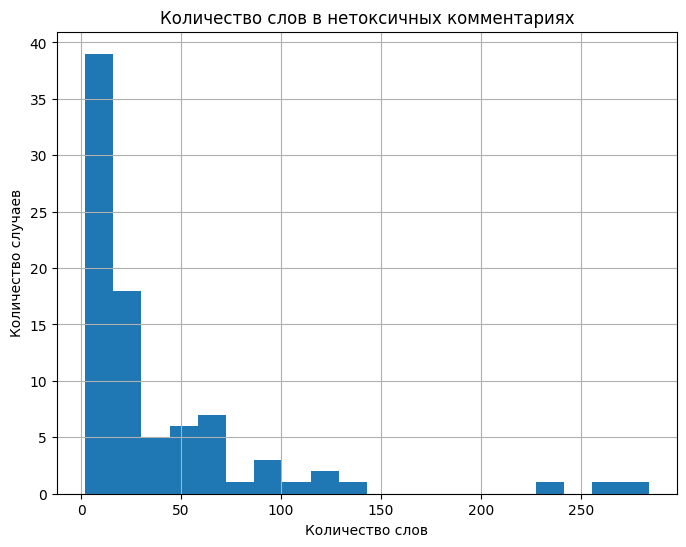

In [88]:
get_hist(
    data_100.query('toxic == 0')['count_words'],
    bins=20,
    title='Количество слов в нетоксичных комментариях',
    x_label='Количество слов'
)

In [30]:
data_100.query('toxic == 1')['count_words'].describe()

count     14.000000
mean      29.857143
std       44.342820
min        4.000000
25%        7.000000
50%       13.000000
75%       29.000000
max      173.000000
Name: count_words, dtype: float64

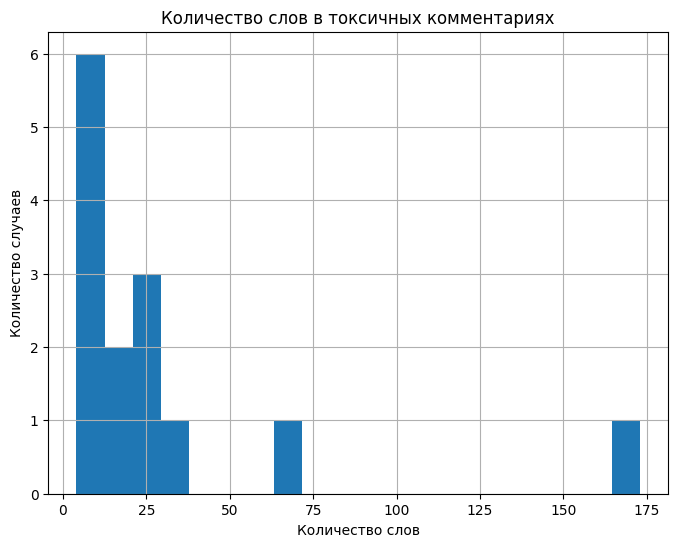

In [90]:
get_hist(
    data_100.query('toxic == 1')['count_words'],
    bins=20,
    title='Количество слов в токсичных комментариях',
    x_label='Количество слов'
)

ВЫВОД

### Наиболее часто встречаемые слова и облако слов

100%|██████████| 86/86 [00:00<00:00, 42307.08it/s]


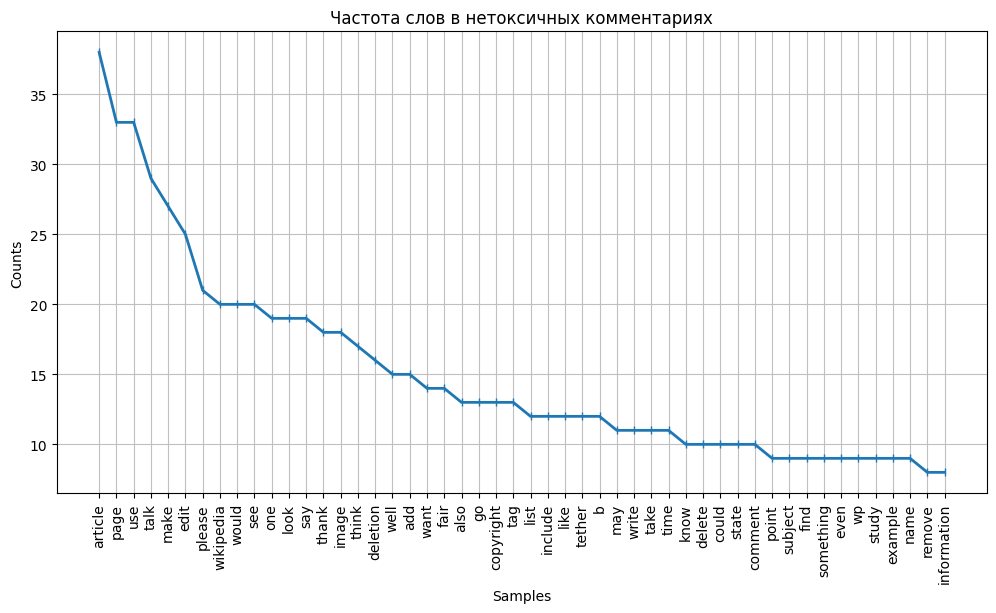

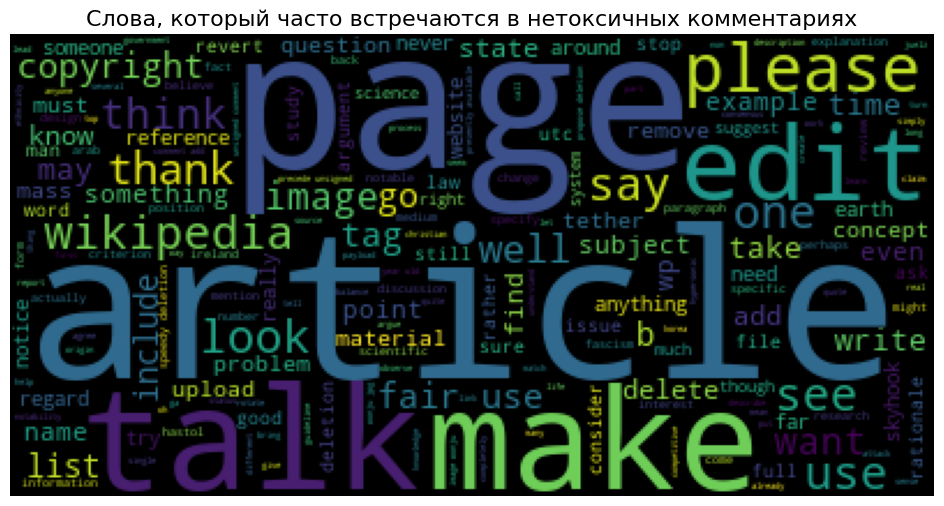

In [50]:
texts_not_toxic = data_100.query('toxic == 0')['text_clean_lemma_without_stopwords']
fdist_not_toxic = get_popular_words(
    texts_not_toxic, 
    50, 
    title='Частота слов в нетоксичных комментариях'
)
get_wordcloud(
    texts_not_toxic,
    'Слова, который часто встречаются в нетоксичных комментариях'
)

100%|██████████| 14/14 [00:00<00:00, 13523.78it/s]


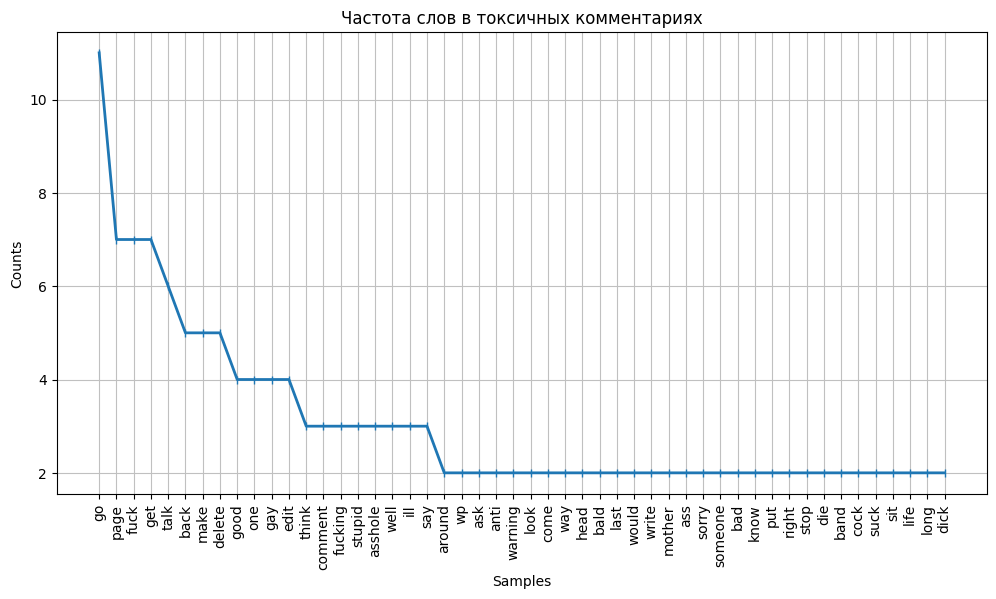

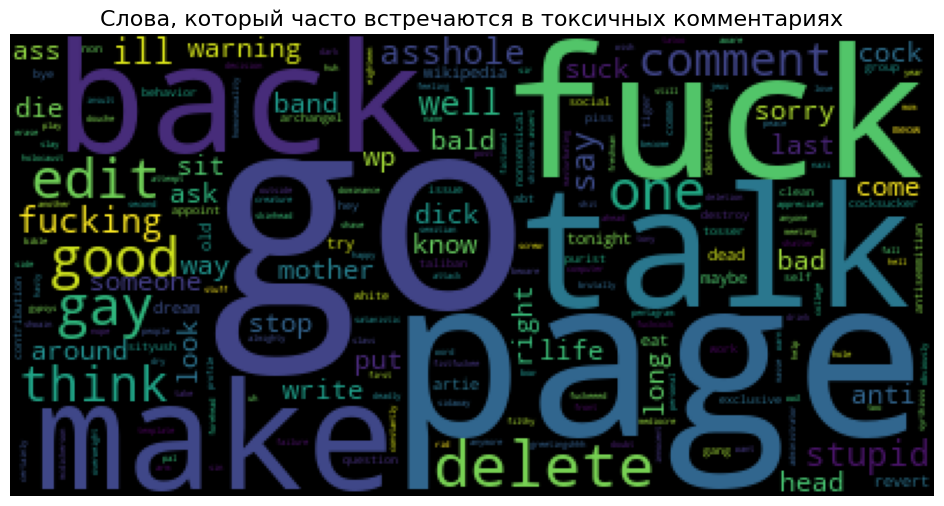

In [49]:
texts_toxic = data_100.query('toxic == 1')['text_clean_lemma_without_stopwords']
fdist_toxic = get_popular_words(
    texts_toxic, 
    50, 
    title='Частота слов в токсичных комментариях'
)
get_wordcloud(
    texts_toxic,
    'Слова, который часто встречаются в токсичных комментариях'
)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

 

Плюс за

    

-  проверку на сбалансированность 



- промежуточный вывод в конце раздела

  


<div class="alert alert-warning">

Совет: 


 
    
- на несбалансированность обратил внимание, это хорошо, но у тебя во всем проекте нет ни одного графика, а ведь красивый, хорошо оформленный график может быть украшением проекта. Почему бы тут его не использовать?   
    
     


- можно также посчитать количество слов в предложений,  длину слов в твите, опять же в разбивке по Таргету.  Если будут какие-то сильные отличия, возможно из-за этого стоит сгенерировать дополнительные признаки для наших моделей. Или например можно использовать библиотеку SentimentIntensityAnalyzer для оценки сантиментов, и посмотреть насколько хорошо ее оценки корелирует с нашими таргетами
   
   
- когда мы работаем с текстами, describe итп описательные статистике не использовать, но можно провести частотный анализ текста.  Предлагаю для этого использовать [облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах (в облаке уже автоматически будут убраны стоп слова). Кроме того графики, рисунки делают проект визуально интересней
   
   
В тренажере облако импортируем так

    !/opt/conda/bin/python -m pip install wordcloud 


или

    !/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  


И возможно дополнительно надо будет сделать



    !pip install --upgrade Pillow  (попробуй версию 9.5.0)

     

### Подготовка текстов. Обучение BERT

In [12]:
if IS_BERT_TRAIN:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    tokenized = data['text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
    )

    max_len = 0
    for i in tokenized.values:
        max_len = max(max_len, len(i))

    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    batch_size = 128
    embeddings = []
    for i in tqdm(range(padded.shape[0] // batch_size + 1)):
        batch = torch.LongTensor(padded[i * batch_size : (i + 1) * batch_size]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[i * batch_size : (i + 1) * batch_size]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    torch.cuda.empty_cache()
    
    features = pd.DataFrame(np.concatenate(embeddings))
    target = data['toxic']
else:
    features = pd.read_csv('data/features.csv')
    target = data['toxic']


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:

    
    
здорово что предусмотрено использование гпу 

    
    
<div class="alert alert-warning">



Совет: 

Есть модели обученных на специальных в текстах и предназначенные для специальных целей, их можно поискать на  на huggingface. Там авторы указывают,на каких данных учили и для каких целей, можно поискать. В частности для нашего датосета возможно будут интересна модель  toxic-bert. Судя по названию она самое то )



    
Подгрузить можно так
    
    
    model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
    tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

In [13]:
del data

### Разделение на выборки

Для подбора параметров модели будем использовать GridSearchCV. Внутри него встроена кросс-валидация. А значит для подбора параметров достаточно разделить выборку на тренировочную и валидационную. Сделаем это в соотношении 80/20

Получение обучающей выборки для подбора параметров модели и валидационной выборки

In [14]:
features_train_gscv, features_valid, target_train_gscv, target_valid = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=RANDOM_STATE
)

Получение обучающей выборки без дисбаланса классов для подбора параметров модели. Увеличили меньший класс в 8 раз

In [15]:
features_train_upsample_gscv, target_train_upsample_gscv = upsample(features_train_gscv, target_train_gscv, 8)

Получение тренировочной и тестовой выборки для подбора threshold модели

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features_train_gscv, target_train_gscv, test_size=0.25, stratify=target_train_gscv, random_state=RANDOM_STATE
)

Получение обучающей выборки без дисбаланса классов для подбора threshold модели. Увеличили меньший класс в 8 раз

In [17]:
features_train_upsample, target_train_upsample = upsample(features_train, target_train, 8)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Верно что перебалансировка сделана только на тренировочной выборке


 


<div class="alert alert-warning">
 

Совет:


- Но валидационный датасет должен иметь первоначальный вид (я о пропорциях нулей и единичек), если ниже используешь GridSearchCV/cros_val_score он будет сбалансирован, в итоге, на валидационном будет завышенная метрика. Можно [почитать](https://datascience.xyz/practice/kak-delat-kross-validaciju-pri-apsemplinge-dannyh.html), тут написано как надо делать правильно (без pipeline никуда)

  
- так ли нам нужен oversampling!? Это скользкая дорожка, критический взгляд на [oversampling](https://habr.com/ru/post/349078/), может просто ограничиться class_weight?!   Хотя если говорить между нами, то работа с  дисбалансом в этом проекте не приводит к улучшению метрики
    
            

## Обучение

Исследовать будем следующие алгоритмы:
1. LogisticRegression  
2. RandomForestClassifier  
3. CatBoostClassifier  

Для каждого типа модели подберем параметры с использованием `class_weight='balanced'` c обучением на обычной несбалансированной выборке и без этого параметра на выборке с решенным дисбалансом

In [18]:
model_results = pd.DataFrame(
    columns=['model', 'best_param', 'gscv_train_score', 'gscv_test_score', 'best_threshold', 'max_f1']
)

### LogisticRegression

#### Борьба с дисбалансом с использованием весов классов

In [ ]:
if IS_SELECTION_PARAMETERS:
    model_log_regression = LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        log_reg_best_param_df = selection_model_params(
            model_log_regression, GSCV_LOG_REGRESSION_CONFIG,
            features_train_gscv, target_train_gscv, 'f1'
        )
    log_reg_best_param_df.to_csv('data/log_reg_best_param.csv', index=False)
elif IS_LOCAL:
    log_reg_best_param_df = pd.read_csv(
        'data/log_reg_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    log_reg_best_param = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('params')]
    log_reg_mean_train_score = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('mean_train_score')]
    log_reg_mean_test_score = log_reg_best_param_df.iloc[0, log_reg_best_param_df.columns.get_loc('mean_test_score')]
else:
    log_reg_best_param = {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
    log_reg_mean_train_score = 0.66
    log_reg_mean_test_score = 0.65
print(f'''train_score = {log_reg_mean_train_score:.2f}
test_score={log_reg_mean_test_score:.2f}
best_param: {log_reg_best_param}''')

train_score = 0.66
test_score=0.65
best_param: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [20]:
model = LogisticRegression(
    max_iter=10_000, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced',
    **log_reg_best_param
)

In [21]:
model.fit(features_train, target_train)

c:\Data\practicum\data_science\wikishop\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, n_jobs=-1,
                   random_state=42, solver='liblinear')

In [22]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:



идея с подбором порога хорошая, действительно так можно поднять метрику на пару вопросов, но мы не делаем это на тестовой выборке. К прогнозу на тестовой выборке подходим с уже одной моделью, выбраными гиперпараметрами, подобранным порогом и т.д. Ведь прогноз на тестовой выборке этой имитация реального прогноза,  а под реальные данные мы подгоняться не можем 


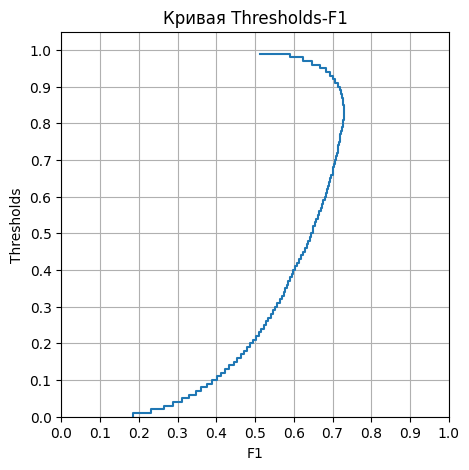

In [23]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [24]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'LogisticRegression weighted balanced', log_reg_best_param,
    log_reg_mean_train_score, log_reg_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.84, max_f1 = 0.73


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:



и для выбора лучшей модели мы не используем тестовую выборку. Для этого у нас есть Метрика на валидации


#### Борьба с дисбалансом методом upsample

In [25]:
if IS_SELECTION_PARAMETERS:
    model_log_regression = LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        log_reg_upsample_best_param_df = selection_model_params(
            model_log_regression, GSCV_LOG_REGRESSION_CONFIG,
            features_train_upsample_gscv, target_train_upsample_gscv, 'f1'
        )
    log_reg_upsample_best_param_df.to_csv('data/log_reg_upsample_best_param.csv', index=False)
elif IS_LOCAL:
    log_reg_upsample_best_param_df = pd.read_csv(
        'data/log_reg_upsample_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    log_reg_upsample_best_param = log_reg_upsample_best_param_df.iloc[
        0, log_reg_upsample_best_param_df.columns.get_loc('params')
    ]
    log_reg_upsample_mean_train_score = log_reg_upsample_best_param_df.iloc[
        0, log_reg_upsample_best_param_df.columns.get_loc('mean_train_score')
    ]
    log_reg_upsample_mean_test_score = log_reg_upsample_best_param_df.iloc[
        0, log_reg_upsample_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    log_reg_upsample_best_param = {'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}
    log_reg_upsample_mean_train_score = 0.9
    log_reg_upsample_mean_test_score = 0.9
print(f'''train_score = {log_reg_upsample_mean_train_score:.2f}
test_score={log_reg_upsample_mean_test_score:.2f}
best_param: {log_reg_upsample_best_param}''')

train_score = 0.90
test_score=0.90
best_param: {'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}


In [26]:
model = LogisticRegression(
    max_iter=10_000, random_state=RANDOM_STATE, n_jobs=-1,
    **log_reg_upsample_best_param
)

In [27]:
model.fit(features_train_upsample, target_train_upsample)

LogisticRegression(C=2, max_iter=10000, n_jobs=-1, random_state=42)

In [28]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

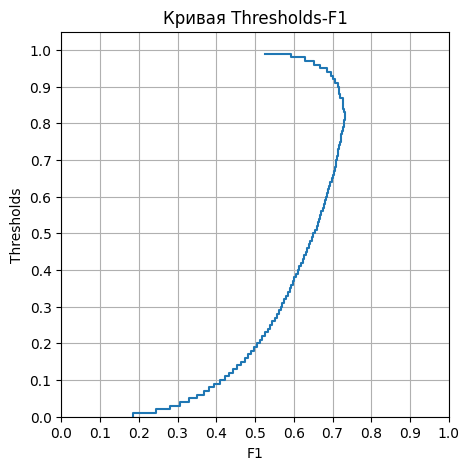

In [29]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [30]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'LogisticRegression upsample', log_reg_upsample_best_param,
    log_reg_upsample_mean_train_score, log_reg_upsample_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.8200000000000001, max_f1 = 0.73


### RanfomForestClassifier

#### Борьба с дисбалансом с использованием весов классов

In [31]:
if IS_SELECTION_PARAMETERS:
    model_random_forest = RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        random_forest_best_param_df = selection_model_params(
            model_random_forest, GSCV_RAND_FOREST_CONFIG,
            features_train_gscv, target_train_gscv, 'f1'
        )
    random_forest_best_param_df.to_csv('data/random_forest_best_param.csv', index=False)
elif IS_LOCAL:
    random_forest_best_param_df = pd.read_csv(
        'data/random_forest_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    random_forest_best_param = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('params')
    ]
    random_forest_mean_train_score = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_train_score')
    ]
    random_forest_mean_test_score = random_forest_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    random_forest_best_param = {'max_depth': 5, 'n_estimators': 171}
    random_forest_mean_train_score = 0.55
    random_forest_mean_test_score = 0.54
print(f'''train_score = {random_forest_mean_train_score:.2f}
test_score={random_forest_mean_test_score:.2f}
best_param: {random_forest_best_param}''')

train_score = 0.55
test_score=0.54
best_param: {'max_depth': 5, 'n_estimators': 171}


In [32]:
model = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced',
    **random_forest_best_param
)

In [33]:
model.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=171,
                       n_jobs=-1, random_state=42)

In [34]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

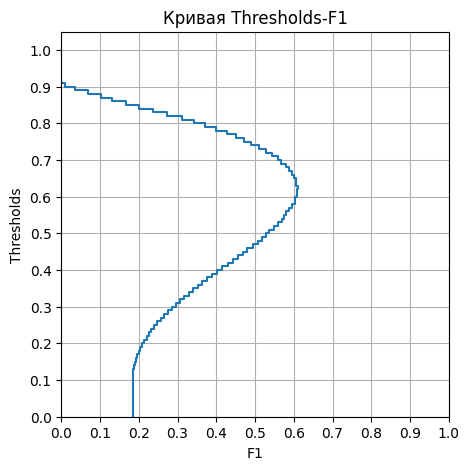

In [35]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [36]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'RandomForestClassifier weighted balanced', random_forest_best_param,
    random_forest_mean_train_score, random_forest_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.62, max_f1 = 0.61


#### Борьба с дисбалансом методом upsample

In [37]:
if IS_SELECTION_PARAMETERS:
    model_random_forest = RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        random_forest_upsample_best_param_df = selection_model_params(
            model_random_forest, GSCV_RAND_FOREST_CONFIG,
            features_train_upsample_gscv, target_train_upsample_gscv, 'f1'
        )
    random_forest_upsample_best_param_df.to_csv('data/random_forest_upsample_best_param.csv', index=False)
elif IS_LOCAL:
    random_forest_upsample_best_param_df = pd.read_csv(
        'data/random_forest_upsample_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    random_forest_upsample_best_param = random_forest_upsample_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('params')
    ]
    random_forest_upsample_mean_train_score = random_forest_upsample_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_train_score')
    ]
    random_forest_upsample_mean_test_score = random_forest_upsample_best_param_df.iloc[
        0, random_forest_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    random_forest_upsample_best_param = {'max_depth': 5, 'n_estimators': 201}
    random_forest_upsample_mean_train_score = 0.83
    random_forest_upsample_mean_test_score = 0.83
print(f'''train_score = {random_forest_upsample_mean_train_score:.2f}
test_score={random_forest_upsample_mean_test_score:.2f}
best_param: {random_forest_upsample_best_param}''')

train_score = 0.83
test_score=0.83
best_param: {'max_depth': 5, 'n_estimators': 201}


In [38]:
model = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1,
    **random_forest_upsample_best_param
)

In [39]:
model.fit(features_train_upsample, target_train_upsample)

RandomForestClassifier(max_depth=5, n_estimators=201, n_jobs=-1,
                       random_state=42)

In [40]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

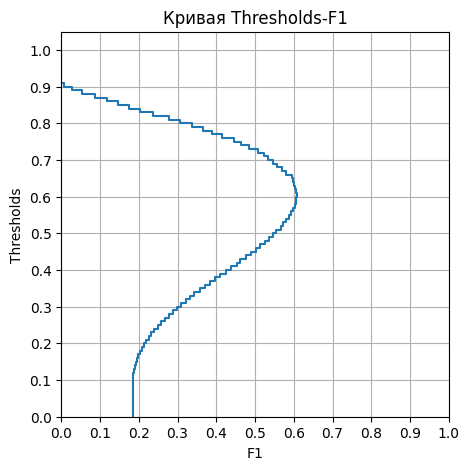

In [41]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [42]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'RandomForestClassifier upsample', random_forest_upsample_best_param,
    random_forest_upsample_mean_train_score, random_forest_upsample_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.6, max_f1 = 0.61


### CatBoostClassifier

#### Борьба с дисбалансом с использованием весов классов

In [43]:
if IS_SELECTION_PARAMETERS:
    task_type = 'GPU' if get_gpu_device_count() else 'CPU'
    model_cat_boost = CatBoostClassifier(
        random_state=RANDOM_STATE, task_type=task_type, auto_class_weights='Balanced'
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cat_boost_best_param_df = selection_model_params(
            model_cat_boost, GSCV_CAT_BOOSRT_CONFIG,
            features_train_gscv, target_train_gscv,
            'f1', cv=5, n_jobs=1
        )
    cat_boost_best_param_df.to_csv('data/cat_boost_best_param.csv', index=False)
elif IS_LOCAL:
    cat_boost_best_param_df = pd.read_csv(
        'data/cat_boost_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    cat_boost_best_param = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('params')
    ]
    cat_boost_mean_train_score = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('mean_train_score')
    ]
    cat_boost_mean_test_score = cat_boost_best_param_df.iloc[
        0, cat_boost_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    cat_boost_best_param = {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}
    cat_boost_mean_train_score = 0.80
    cat_boost_mean_test_score = 0.66
print(f'''train_score = {cat_boost_mean_train_score:.2f}
test_score={cat_boost_mean_test_score:.2f}
best_param: {cat_boost_best_param}''')

train_score = 0.80
test_score=0.66
best_param: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}


In [44]:
task_type = 'GPU' if get_gpu_device_count() else 'CPU'
model = CatBoostClassifier(
    random_state=RANDOM_STATE, task_type=task_type, auto_class_weights='Balanced',
    **cat_boost_best_param
)

In [45]:
model.fit(features_train, target_train)

0:	learn: 0.5405336	total: 858ms	remaining: 4m 16s
1:	learn: 0.4630439	total: 1.2s	remaining: 2m 58s
2:	learn: 0.4231290	total: 1.53s	remaining: 2m 31s
3:	learn: 0.3926513	total: 1.91s	remaining: 2m 21s
4:	learn: 0.3761075	total: 2.19s	remaining: 2m 9s
5:	learn: 0.3658440	total: 2.52s	remaining: 2m 3s
6:	learn: 0.3563525	total: 2.79s	remaining: 1m 56s
7:	learn: 0.3477197	total: 3.03s	remaining: 1m 50s
8:	learn: 0.3402295	total: 3.28s	remaining: 1m 46s
9:	learn: 0.3330041	total: 3.53s	remaining: 1m 42s
10:	learn: 0.3283312	total: 3.75s	remaining: 1m 38s
11:	learn: 0.3246717	total: 4.01s	remaining: 1m 36s
12:	learn: 0.3211632	total: 4.24s	remaining: 1m 33s
13:	learn: 0.3178518	total: 4.46s	remaining: 1m 31s
14:	learn: 0.3154635	total: 4.71s	remaining: 1m 29s
15:	learn: 0.3128086	total: 4.97s	remaining: 1m 28s
16:	learn: 0.3096718	total: 5.21s	remaining: 1m 26s
17:	learn: 0.3071324	total: 5.46s	remaining: 1m 25s
18:	learn: 0.3043713	total: 5.72s	remaining: 1m 24s
19:	learn: 0.3019316	tota

In [46]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

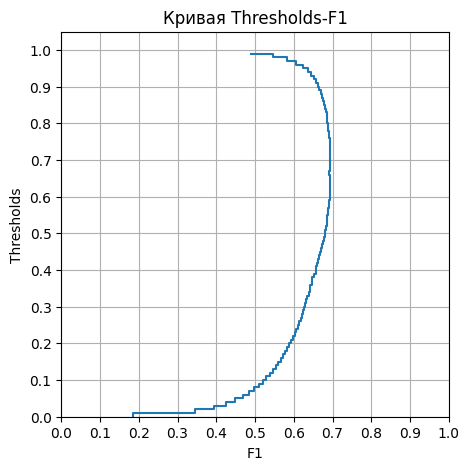

In [47]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [48]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'CatBoostClassifier weights balanced', cat_boost_best_param,
    cat_boost_mean_train_score, cat_boost_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.71, max_f1 = 0.69


#### Борьба с дисбалансом методом upsample

In [49]:
if IS_SELECTION_PARAMETERS:
    task_type = 'GPU' if get_gpu_device_count() else 'CPU'
    model_cat_boost = CatBoostClassifier(
        random_state=RANDOM_STATE, task_type=task_type
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cat_boost_upsample_best_param_df = selection_model_params(
            model_cat_boost, GSCV_CAT_BOOSRT_CONFIG,
            features_train_upsample_gscv, target_train_gscv,
            'f1', cv=5, n_jobs=1
        )
    cat_boost_upsample_best_param_df.to_csv('data/cat_boost_upsample_best_param.csv', index=False)
elif IS_LOCAL:
    cat_boost_upsample_best_param_df = pd.read_csv(
        'data/cat_boost_upsample_best_param.csv',
        converters={
            'params': lambda x: loads(x.replace("'", '"'))
        }
    )

if IS_LOCAL:
    cat_boost_upsample_best_param = cat_boost_upsample_best_param_df.iloc[
        0, cat_boost_upsample_best_param_df.columns.get_loc('params')
    ]
    cat_boost_upsample_mean_train_score = cat_boost_upsample_best_param_df.iloc[
        0, cat_boost_upsample_best_param_df.columns.get_loc('mean_train_score')
    ]
    cat_boost_upsample_mean_test_score = cat_boost_upsample_best_param_df.iloc[
        0, cat_boost_upsample_best_param_df.columns.get_loc('mean_test_score')
    ]
else:
    cat_boost_upsample_best_param = {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 300}
    cat_boost_upsample_mean_train_score = 0.98
    cat_boost_upsample_mean_test_score = 0.95
print(f'''train_score = {cat_boost_upsample_mean_train_score:.2f}
test_score={cat_boost_upsample_mean_test_score:.2f}
best_param: {cat_boost_upsample_best_param}''')

train_score = 0.98
test_score=0.95
best_param: {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 300}


In [50]:
task_type = 'GPU' if get_gpu_device_count() else 'CPU'
model = CatBoostClassifier(
    random_state=RANDOM_STATE, task_type=task_type,
    **cat_boost_upsample_best_param
)

In [51]:
model.fit(features_train, target_train)

0:	learn: 0.2683508	total: 259ms	remaining: 1m 17s
1:	learn: 0.2252113	total: 487ms	remaining: 1m 12s
2:	learn: 0.2099328	total: 730ms	remaining: 1m 12s
3:	learn: 0.2006853	total: 998ms	remaining: 1m 13s
4:	learn: 0.1919643	total: 1.27s	remaining: 1m 15s
5:	learn: 0.1853640	total: 1.53s	remaining: 1m 14s
6:	learn: 0.1811921	total: 1.85s	remaining: 1m 17s
7:	learn: 0.1785019	total: 2.08s	remaining: 1m 16s
8:	learn: 0.1756489	total: 2.34s	remaining: 1m 15s
9:	learn: 0.1721188	total: 2.59s	remaining: 1m 15s
10:	learn: 0.1702110	total: 2.8s	remaining: 1m 13s
11:	learn: 0.1679505	total: 3.06s	remaining: 1m 13s
12:	learn: 0.1659400	total: 3.31s	remaining: 1m 13s
13:	learn: 0.1642893	total: 3.51s	remaining: 1m 11s
14:	learn: 0.1628414	total: 3.71s	remaining: 1m 10s
15:	learn: 0.1613315	total: 4.01s	remaining: 1m 11s
16:	learn: 0.1593291	total: 4.26s	remaining: 1m 10s
17:	learn: 0.1579141	total: 4.48s	remaining: 1m 10s
18:	learn: 0.1564886	total: 4.71s	remaining: 1m 9s
19:	learn: 0.1550444	tot

In [52]:
predict_proba = model.predict_proba(features_test)

thresholds, f1 = [], []
for threshold in np.arange(0, 1, 0.01):
    f1.append(f1_score(
        target_test,
        predict_proba[:, 1] > threshold
    ))
    thresholds.append(threshold)

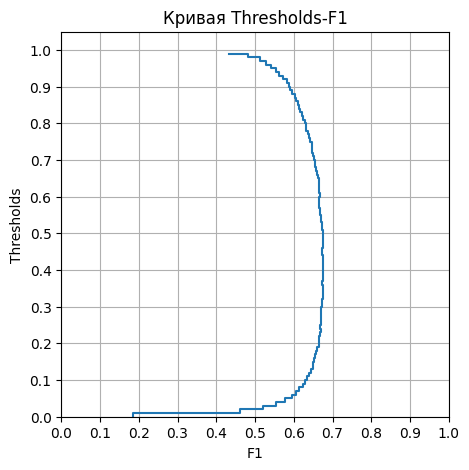

In [53]:
create_threshold_f1_plot(f1=f1, thresholds=thresholds)

In [54]:
max_f1 = max(f1)
best_threshold = thresholds[f1.index(max_f1)]
model_results.loc[len(model_results)] = [
    'CatBoostClassifier upsample', cat_boost_upsample_best_param,
    cat_boost_upsample_mean_train_score, cat_boost_upsample_mean_test_score,
    best_threshold, max_f1
]
print(f'best_threshold = {best_threshold}, max_f1 = {max_f1:.2f}')

best_threshold = 0.42, max_f1 = 0.68


### Результаты

In [55]:
with pd.option_context('display.max_colwidth', None):
    display(model_results)

,model,best_param,gscv_train_score,gscv_test_score,best_threshold,max_f1
0,LogisticRegression weighted balanced,"{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}",0.66,0.65,0.84,0.729897
1,LogisticRegression upsample,"{'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}",0.90,0.90,0.82,0.731981
2,RandomForestClassifier weighted balanced,"{'max_depth': 5, 'n_estimators': 171}",0.55,0.54,0.62,0.610153
3,RandomForestClassifier upsample,"{'max_depth': 5, 'n_estimators': 201}",0.83,0.83,0.60,0.607972
4,CatBoostClassifier weights balanced,"{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}",0.80,0.66,0.71,0.694535
5,CatBoostClassifier upsample,"{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 300}",0.98,0.95,0.42,0.675566


Из таблицы можно увидеть, что лучшее качество имеет модель `LogisticRegression`, обученная на upsample выборке. При подборе параметров удалось добиться метрики f1 равной `0.897` на обучающей выборке и `0.895` на тестовой выборке. Лучшие параметры: `{'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}`. При этом при подборе оптимального threshold качество модели заметро уменьшается. Лучший `threshold = 0.84`, при этом `f1=0.73`. Скорее всего, такое падение качестыва связано с тем, что при подборе параметров качество проверялось на выборке без дисбаланса классов. А на выборке, которая будет использоваться при эксплуатации качество проседает. Однако добиться качества лучше не получилось. Поэтому будет использоваться именно эта модель 

### Проверка на валидационной выборке

In [56]:
best_threshold = 0.82
best_param = {'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}
best_model = LogisticRegression(
    random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1,
    **best_param
)
best_model.fit(features_train_upsample, target_train_upsample)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1, random_state=42)




<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>
    
    
Совет:



    


Не надо воспринимать  GS как способ получить .best_params_, чтобы подставить их в модель и обучить на них. GS это сделал уже и модельку положил тут: .best_estimator_
    
   

In [57]:
predict_proba = best_model.predict_proba(features_valid)
f1 = f1_score(target_valid, predict_proba[:, 1] > best_threshold)
print(f'f1 = {f1}')

f1 = 0.7338461538461538


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:


Метрика не достигнута
Самый простой способ поднять метрику -  использовать предобученную модель которую я подсказал


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 

 

- Как мы еще можем использовать Берт?  Можно потюнить модель Берта,  можешь взять на основу [статью (там вообще все возможные варианты рассмотрены, причём с использованием разных библиотек)](https://habr.com/ru/articles/704592/) или этот [ролик](https://www.youtube.com/watch?v=Z1J3sTJYIcc&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=14), там прямо можно посмотреть процесс кодирования, и получше разобраться в практической релизации Берта (тут реализация сложнее, метрики я видел за 0,8). Если использовать [Trainer](https://pytorch.org/rl/reference/generated/torchrl.trainers.Trainer.html), будет всё гораздо проще. 
    
    
 

- Можно попробовать TFIDF, это устаревший подход, но зато есть возможность попрактиковаться в использовании связки pipeline+gridsearch и лемматизации (там есть свои тонкости). А в конце можно посмотреть какие слова модель считают наиболее важными - интересная информация

 

## Выводы

В ходе работы была разработана модель определения токсичности комментариев. Для создания эмбедингов была обучена модель BERT. Модель для классификации выбиралась из `LogisticRegression`, `RandomForest`, `CatBoostRegression`. Для подбора гиперпарамаетров использовался GridSearchCV с кросс-валидацией на 5 фолдах. В датасете имеется дисбаланс классов. Токсичные комментарии составляют лишь 10%. Для борьбы с дисбалансом использовалось 2 метода:  
* Использование весов для классов  
* Увеличение выборки методом upsample  
  
При этом в валидационной выборке и тестовой выборке (во время подбора threshold) дисбаланс классов не устранялся.  
Были получены следующие результаты исследования:  
||model|	best_param|	gscv_train_score|	gscv_test_score|	best_threshold|	max_f1|
|-|-|-|-|-|-|-|
|0|	LogisticRegression weighted balanced|	{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}|	0.658688|	0.648852|	0.84|	0.729897|
|1|	LogisticRegression upsample|	{'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}|	0.897196|	0.895391|	0.82|	0.731981|
|2|	RandomForestClassifier weighted balanced|	{'max_depth': 5, 'n_estimators': 171}|	0.551477|	0.538978|	0.62|	0.610153|
|3|	RandomForestClassifier upsample|	{'max_depth': 5, 'n_estimators': 201}|	0.828230|	0.825686|	0.60|	0.607972|
|4|	CatBoostClassifier weights balanced|	{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300}|	0.800791|	0.662807|	0.71|	0.694535|
|5|	CatBoostClassifier upsample	|{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 300}|	0.975030|	0.951962|	0.42|	0.675566|  
  
Из таблицы можно увидеть, что лучшее качество имеет модель `LogisticRegression`, обученная на upsample выборке. При подборе параметров удалось добиться метрики f1 равной `0.897` на обучающей выборке и `0.895` на тестовой выборке. Лучшие параметры: `{'C': 2, 'penalty': 'l2', 'solver': 'lbfgs'}`. При этом при подборе оптимального threshold качество модели заметро уменьшается. Лучший `threshold = 0.84`, при этом `f1=0.73`. Скорее всего, такое падение качестыва связано с тем, что при подборе параметров качество проверялось на выборке без дисбаланса классов. А на выборке, которая будет использоваться при эксплуатации качество проседает. Однако добиться качества лучше не получилось. Поэтому будет использоваться именно эта модель 


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Александр, у тебя старательно выполненная работа, все четко, осмысленно. 



Нет проблем с комментированием кода - всё что ты делаешь понятно

 


Выводы присутствуют, они четкие и подробные.


GS использован корректно. Здорово Что пробовал поднимать метрику с помощью порога, здорово что использовал продвинутый подход с использованием Берта. Предусмотрел возможность использования ГПУ

 


Дополнительно можно:

 

-  построить облако для токсичных и нетоксичных комментариев



-  заглянуть внутрь модели (Если попробовать TFIDF), можешь посмотреть какой из признаков является наиболее важный для логистической регресси (должно получиться слово fuck)   

 


Обязательное к исправлению:


 
    
- подгонка при использовании тестовой выборки для подбора порога. Тестовый выборку используем только один раз, в самом конце    
    

- не достигнута f1 > 0,75 на тестовом датасета



 



Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны